In [1]:
import pickle
import random
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from os.path import exists

random.seed(2021)

## Question 0

In [2]:
# tooth growth data
file = 'tooth_growth.feather'
if exists(file):
    tg_data = pd.read_feather(file)
else: 
    tooth_growth = sm.datasets.get_rdataset('ToothGrowth')
    tg_data = tooth_growth.data
    tg_data.to_feather(file)

# transform data
tg_data['log_len'] = tg_data[['len']].transform(np.log)
tg_data['dose_cat'] = pd.Categorical(tg_data['dose'])
tg_data['OJ'] = pd.get_dummies(tg_data['supp'])['OJ']

# fit the model
mod1 = smf.ols('log_len ~ OJ*dose_cat', data=tg_data)
fit1 = mod1.fit()
fit1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:               OLS              Adj. R-squared:     0.775   
Dependent Variable:  log_len          AIC:                3.4775  
Date:                2021-11-06 16:51 BIC:                16.0436 
No. Observations:    60               Log-Likelihood:     4.2612  
Df Model:            5                F-statistic:        41.69   
Df Residuals:        54               Prob (F-statistic): 2.34e-17
R-squared:           0.794            Scale:              0.056441
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept           2.0208   0.0751 26.8989 0.0000  1.8702  2.1715
dose_cat[T.1.0]     0.7893   0.1062  7.4294 0.0000  0.5763  1.0024
dose_cat[T.2.0]     1.2273   0.1062 11.5513 0.0000  1.0143  1.4403
OJ                  0.5118   0.1062  4.8171 0.0000  0.2988  0.7248
OJ:dose_cat[T.1.0] -0.2148   0.1503 -1.4297 0.1586 -0.5161  0.0864
OJ:dose_cat[T.2.0] -0.5041   0.1503 -3.3551 0.0015 -0.8054 -0.2029
------------------------------------------------------------------
Omnibus:              0.136         Durbin-Watson:           1.862
Prob(Omnibus):        0.934         Jarque-Bera (JB):        0.039
Skew:                 -0.058        Prob(JB):                0.981
Kurtosis:             2.953         Condition No.:           10   
==================================================================

"""

The R-Squared is calculated as follow,
$$R ^ 2 = \frac{\sum_i (\hat y_i - \bar y) ^ 2}{\sum_i (y_i - \bar y) ^ 2}$$

In [3]:
R2 = fit1.ess / fit1.centered_tss
R2

0.7942457970936073

The Adjusted R-Squared  is calculated as follow,
$$R ^ 2 \text{-adjusted} = 1 - \frac{(1 - R ^ 2)(n - 1)}{n - p - 1}$$

In [4]:
R2_adj = 1 - (1 - R2) * (fit1.nobs - 1) / (fit1.nobs - 5 - 1)
R2_adj

0.7751944820096821

In [5]:
print(round(R2, 3) == round(fit1.rsquared, 3))
print(round(R2_adj, 3) == round(fit1.rsquared_adj, 3))

True
True


The Computed R sqaure and Adjusted R-Squared  is the same with result object.

## Question 1 

### a.

In [6]:
# the NHANES dentition and demographics data from problem sets 2 and 4
df_demo = pickle.load(open("DEMO.pkl", "rb"))
df_ohxden = pickle.load(open("OHXDEN.pkl", "rb"))
df_raw = pd.merge(df_demo[["id", "age"]], df_ohxden[df_ohxden.columns[:34]], 
                  how="outer", on=["id"])

# limit the analyses to those age 12 and older
df = df_raw.copy()
df = df[df['age'] >= 12]
df.index = range(len(df))

# transform data to bernoulli variables
for i in range(3, 35):
    df[df.columns[i]] = df[df.columns[i]].apply(lambda x: 1 if x == 2 else 0)

In [7]:
aic = 10000
for k in range(3, 6):
    for i in range(50):
        knot = sorted(random.sample(range(14, 80), k))
        str_bs = 'tooth_count1 ~ bs(age, knots=' + str(knot) + ', degree=3)'
        fit_bs = smf.logit(str_bs, data=df).fit(disp=False)
        aic_new = fit_bs.aic
        if aic_new < aic:
            knot = knot
            aic = aic_new
knot

[14, 17, 20, 24, 71]

To find the best fit model, I tried different lengths of knots and different knots. The procedure is:
1. choose the length of knots (3 or 4 or 5),
2. randomly choose the values of knots,
3. fit the logistic regression model and calculate the AIC value,
4. repeat the 1 - 3 for a different length of knots,
5. select the model with the minimum AIC value.

Then the final model's knots is [14, 17, 20, 24, 71] and degree is 3

### b.

In [8]:
# fit the model to all other teeth in the data
for i in range(3, 35):
    str_bs = str(df.columns[i]) + ' ~ bs(age, knots=' + str(knot) + ', degree=3)'
    fit_bs = smf.logit(str_bs, data=df).fit(disp=False)
    df[str(df.columns[i]) + '_pred'] = fit_bs.predict()

### c.

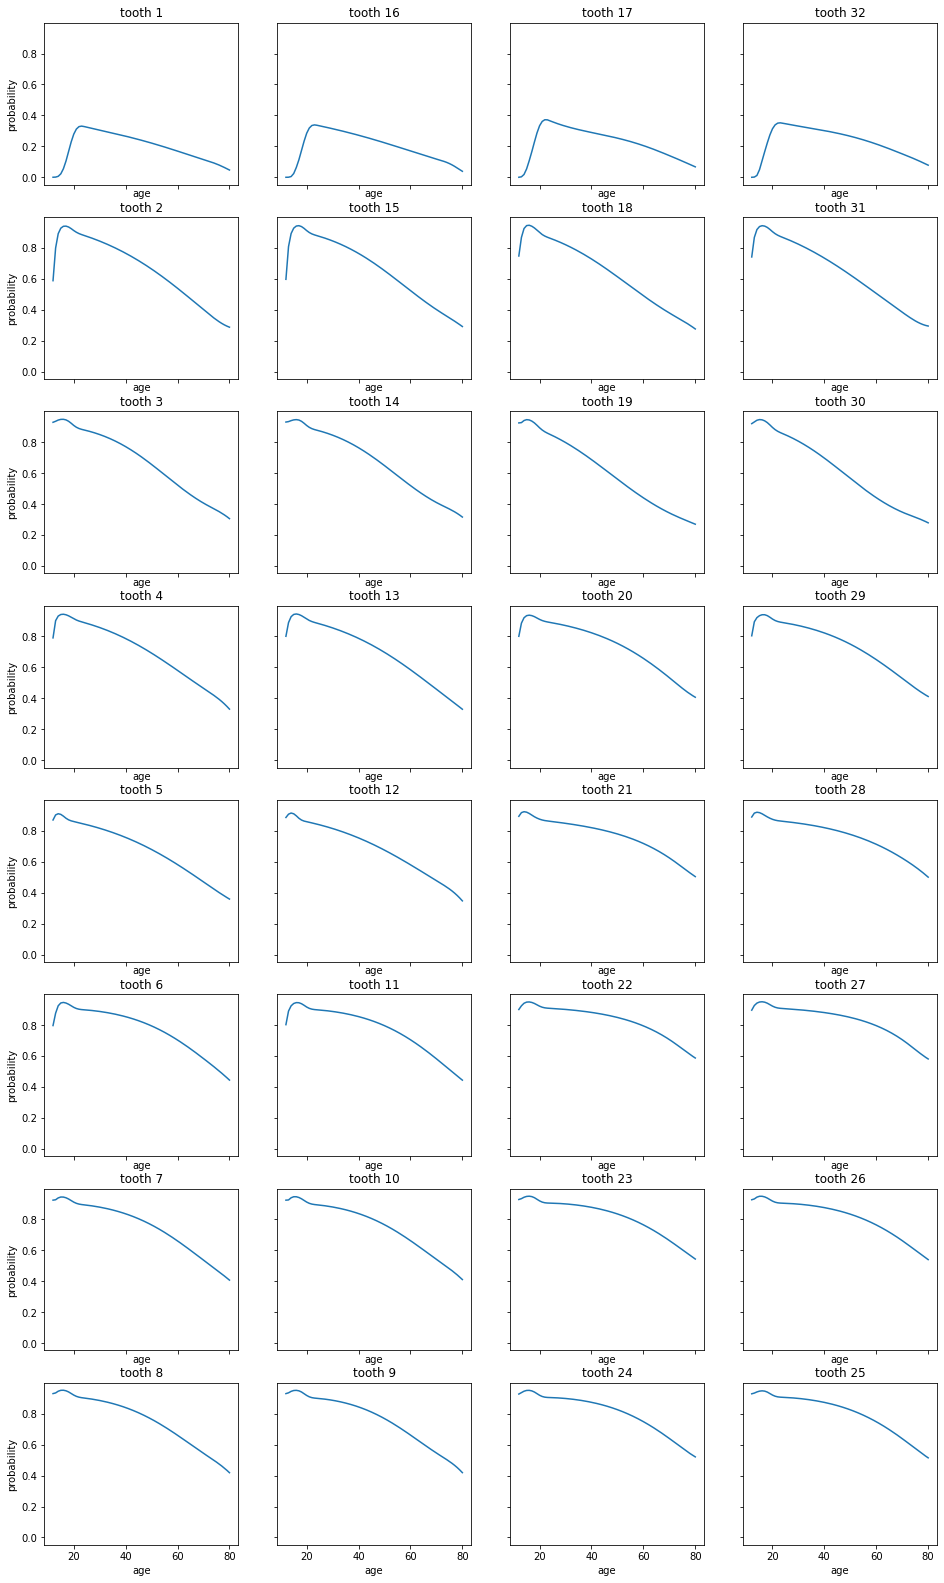

In [9]:
position = (
    list(range(1, 9)) + 
    list(reversed(range(9, 17))) + 
    list(range(17, 25)) + 
    list(reversed(range(25, 33)))
)

# visualization showing the predicted probability for each tooth
df_1c = df.sort_values('age')
fig, ax = plt.subplots(nrows=8, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(16, 28)
for i in range(32):
    r = (position[i] - 1) % 8
    c = i // 8
    str_col = str(df_1c.columns[i + 35])
    ax[r, c].plot(df_1c['age'], df_1c[str_col])
    ax[r, c].set_title('tooth ' + str(i + 1))
    ax[r, c].set_xlabel('age')
    if c == 0:
        ax[r, c].set_ylabel('probability')

## Question 2

### 1.

In [10]:
def split(values, li):
    cata = []
    for x in values:
        for i in range(10):
            if li[i] <= x and x < li[i+1]:
                cata.append(i)
    return cata

df_2a = df.sort_values('tooth_count1_pred')
df_2a.index = range(len(df_2a.index))

li1 = np.linspace(0, len(df), 11, dtype=int)
li1[10] = li1[10] + 1
df_2a['group'] = split(df_2a.index, li1)

### 2.

In [11]:
df_decile = df_2a.groupby('group').mean()[['tooth_count1', 'tooth_count1_pred']]
df_decile.columns = ['observed probabilities', 'expected probabilities']
df_decile

,observed probabilities,expected probabilities
group,,
0,0.007186,0.008366
1,0.055336,0.053705
2,0.106001,0.106155
3,0.153072,0.147838
4,0.170259,0.177455
5,0.222063,0.214174
6,0.237873,0.242922
7,0.265541,0.273416
8,0.300395,0.299125


### 3.

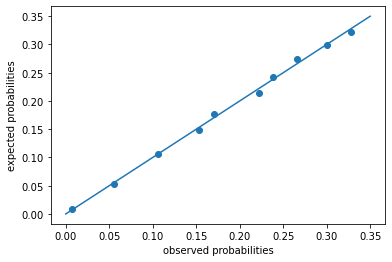

In [12]:
plt.scatter(df_decile['observed probabilities'], df_decile['expected probabilities'])
plt.plot([0, 0.35], [0, 0.35])
plt.xlabel('observed probabilities')
plt.ylabel('expected probabilities')
plt.show()

### 4.

From the figure, I thinl the model is well-calibrated because the points in this plot fall approximately on this line.